# Target encoding

- [Feature Selection in Machine Learning Book](https://www.trainindata.com/p/feature-selection-in-machine-learning-book)

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import SelectByTargetMeanPerformance

In [3]:
# load titanic dataset

variables = ['pclass', 'survived', 'sex', 'age',
             'sibsp', 'parch', 'fare', 'cabin', 'embarked']

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl',
                   usecols=variables,
                   na_values='?',
                   dtype={'fare': float, 'age': float},
                   )

data.dropna(subset=['embarked', 'fare'], inplace=True)
data['age'] = data['age'].fillna(data['age'].mean())


def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return 'N'


data['cabin'] = data['cabin'].apply(get_first_cabin).str[0]
encoder = RareLabelEncoder(variables='cabin', n_categories=2)
data = encoder.fit_transform(data)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,Rare,S
1,1,1,male,0.9167,1,2,151.5500,C,S
2,1,0,female,2.0000,1,2,151.5500,C,S
3,1,0,male,30.0000,1,2,151.5500,C,S
4,1,0,female,25.0000,1,2,151.5500,C,S


## Feature-engine

In [4]:
# separate data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),
    data['survived'],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((914, 8), (392, 8))

In [5]:
sel = SelectByTargetMeanPerformance(
    bins=5,
    strategy='equal_frequency',
    scoring='roc_auc',
    cv=2,
    threshold=None,
    regression=False,
)

sel.fit(X_train, y_train)

SelectByTargetMeanPerformance(cv=2, strategy='equal_frequency')

In [6]:
# the features that will be removed

sel.features_to_drop_

['age', 'sibsp', 'parch', 'embarked']

In [7]:
# the performance estimated for each feature

sel.feature_performance_

{'pclass': np.float64(0.6551893232380663),
 'sex': np.float64(0.7491001943282519),
 'age': np.float64(0.5382483653274581),
 'sibsp': np.float64(0.5183970828336429),
 'parch': np.float64(0.5068146044866522),
 'fare': np.float64(0.6753892717910286),
 'cabin': np.float64(0.6385761238147736),
 'embarked': np.float64(0.5630695122556864)}

In [8]:
# we also obtain the standard deviation of the performance

sel.feature_performance_std_

{'pclass': np.float64(0.026413779804051962),
 'sex': np.float64(0.013795301386788084),
 'age': np.float64(0.010406279303332377),
 'sibsp': np.float64(0.010957939301932451),
 'parch': np.float64(0.003453652453834666),
 'fare': np.float64(0.015961607539624112),
 'cabin': np.float64(0.011021780413324356),
 'embarked': np.float64(0.009998194173784447)}

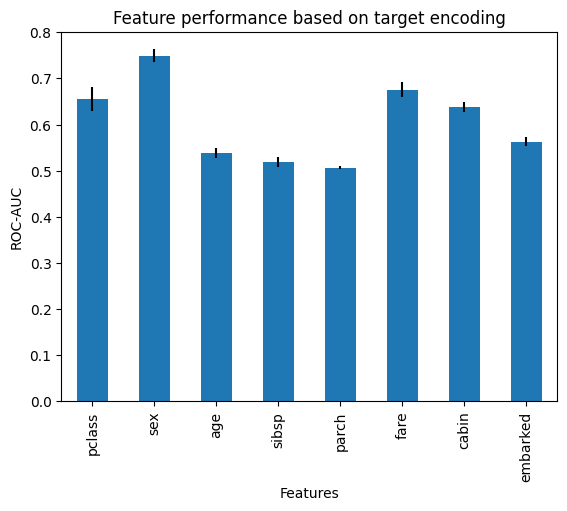

In [9]:
r = pd.concat([
    pd.Series(sel.feature_performance_),
    pd.Series(sel.feature_performance_std_)
], axis=1
)
r.columns = ['mean', 'std']

r['mean'].plot.bar(yerr=[r['std'], r['std']], subplots=True)

plt.title("Feature performance based on target encoding")
plt.ylabel('ROC-AUC')
plt.xlabel('Features')
plt.show()

In [10]:
# drop features

X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_train_t.shape, X_test_t.shape

((914, 4), (392, 4))

In [11]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
842,3,male,29.813199,1,0,19.9667,N,S
868,3,male,43.000000,0,0,6.4500,N,S
429,2,male,44.000000,0,0,13.0000,N,S
480,2,male,25.000000,1,2,41.5792,N,C
1308,3,male,29.000000,0,0,7.8750,N,S


## Manual

First, I will demonstrate the feature selection procedure over categorical variables. 

The Titanic dataset contains 4 categorical variables, which are Sex, Pclass, Cabin and Embarked.

In [12]:
# Separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data[['pclass', 'sex', 'embarked', 'cabin']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Replace categories by target mean

In [13]:
def mean_encoding(df_train, df_test, target):
    
    # copy of the original dataframes
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()
    
    # iterate over each variable
    for col in df_train.columns:
        
        # make a dictionary of categories: target-mean pairs
        target_mean_dict = target.groupby(df_train[col]).mean().to_dict()
        
        # replace the categories by the mean of the target
        df_train_temp[col] = df_train[col].map(target_mean_dict)
        df_test_temp[col] = df_test[col].map(target_mean_dict)
    
    # return  re-mapped datasets
    return df_train_temp, df_test_temp

In [14]:
X_train_enc, X_test_enc = mean_encoding(X_train, X_test, y_train)

X_train_enc.head()

,pclass,sex,embarked,cabin
842,0.243902,0.199664,0.338534,0.295875
868,0.243902,0.199664,0.338534,0.295875
429,0.416667,0.199664,0.338534,0.295875
480,0.416667,0.199664,0.545946,0.295875
1308,0.243902,0.199664,0.338534,0.295875


In [15]:
X_test_enc.head()

,pclass,sex,embarked,cabin
611,0.243902,0.199664,0.338534,0.295875
414,0.416667,0.199664,0.338534,0.295875
530,0.416667,0.199664,0.338534,0.295875
1149,0.243902,0.716981,0.329545,0.295875
944,0.243902,0.199664,0.338534,0.295875


The strings were replaced by the target mean.

### Determine the roc-auc

In [16]:
# Calculate a roc-auc using the encoded variables
# as predictions

roc_values = [
    roc_auc_score(y_test, X_test_enc[feature]) for feature in X_test.columns
]

roc_values

[np.float64(0.6303893819900525),
 np.float64(0.7841636668407024),
 np.float64(0.5733423099117914),
 np.float64(0.6118408397680746)]

In [17]:
# I make a series for easy visualisation

m1 = pd.Series(roc_values, index=X_test.columns).sort_values(ascending=False)

m1

sex         0.784164
pclass      0.630389
cabin       0.611841
embarked    0.573342
dtype: float64

## Feature Selection on numerical variables

I will work with the numerical variables Age and Fare.

In [18]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((914, 2), (392, 2))

### Bin variable Age

In [19]:
# Let's divide Age in 5 bins.

X_train['age_binned'], intervals = pd.qcut(
    X_train['age'],
    q = 5,
    labels=False,
    retbins=True,
    precision=3,
    duplicates='drop',
)

X_train[['age_binned', 'age']].head(10)

,age_binned,age
842,2,29.813199
868,4,43.000000
429,4,44.000000
480,1,25.000000
1308,1,29.000000
455,4,63.000000
117,3,30.000000
484,3,34.000000
296,3,39.000000
262,4,50.000000


In [20]:
# count the number of distinct bins

X_train['age_binned'].nunique()

5

In [21]:
# display the bins

X_train['age_binned'].unique()

array([2, 4, 1, 3, 0])

In [22]:
# Now I use the interval limits calculated in the previous cell to
# bin the testing set

X_test['age_binned'] = pd.cut(x = X_test['age'], bins=intervals, labels=False)

X_test[['age_binned', 'age']].head(10)

,age_binned,age
611,0.0,0.833300
414,3.0,34.000000
530,0.0,19.000000
1149,2.0,29.813199
944,2.0,29.813199
872,2.0,29.813199
5,4.0,48.000000
232,4.0,47.000000
733,0.0,9.000000
1292,2.0,29.813199


### Bin Variable Fare

In [23]:
# train
X_train['fare_binned'], intervals = pd.qcut(
    X_train['fare'],
    q=5,
    labels=False,
    retbins=True,
    precision=3,
    duplicates='drop',
)

# test
X_test['fare_binned'] = pd.cut(x = X_test['fare'], bins=intervals, labels=False)

In [24]:
X_test['fare_binned'].nunique()

5

In [25]:
X_test.isnull().sum()

age            0
fare           0
age_binned     2
fare_binned    5
dtype: int64

In [26]:
# test set shows missing data. The missing values in 
# the test set appear when the original values are outside
# the boundaries of the invervals determined in the train set
# that is, values that are smaller or bigger than the min and max
# values from the train set

# to speed out the demo, I will just replace them by 0 in this notebook

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Replace bins with target mean

In [27]:
# now we use our previous function to encode the variables
# with the target mean

binned_vars = ['age_binned', 'fare_binned']

X_train_enc, X_test_enc = mean_encoding(
    X_train[binned_vars], X_test[binned_vars], y_train)

X_train_enc.head()

,age_binned,fare_binned
842,0.254237,0.367232
868,0.421965,0.256831
429,0.421965,0.367232
480,0.379487,0.629834
1308,0.379487,0.207447


### Determine roc-auc using encodings

In [28]:
# now, we calculate a roc-auc value, using the encoded variables
# as predictions

roc_values = [
    roc_auc_score(y_test, X_test_enc[feature]) for feature in binned_vars
]



In [29]:
# I make a series for easy visualisation

m1 = pd.Series(roc_values, index=binned_vars).sort_values(ascending=False)

m1

fare_binned    0.666964
age_binned     0.497335
dtype: float64